In [99]:
import json, csv, re, unicodedata, requests
from pathlib import Path
from typing import Any, Dict, Iterable, List
from collections import Counter, defaultdict
import random, math, textwrap, os
import networkx as nx
import matplotlib.pyplot as plt

## Helper Functions

In [100]:
# Standardize text spacing, newlines, and encoding.
def normalize_text(s: str) -> str:
    s = unicodedata.normalize("NFC", s or "")
    s = s.replace("\r\n","\n").replace("\r","\n")
    s = re.sub(r"[ \t]+"," ", s)
    s = re.sub(r"\n{3,}","\n\n", s)
    return s.strip()

# Clean up and title-case names or entity labels.
def normalize_name(s: str) -> str:
    return re.sub(r"\s+"," ", (s or "").strip()).title()

# Safely parse a JSON string with a fallback to first JSON block.
def safe_parse_json(s: str) -> Any:
    try:
        return json.loads(s)
    except Exception:
        m = re.search(r"(\{.*\}|\[.*\])", s or "", flags=re.S)
        if not m:
            raise ValueError("Invalid JSON")
        return json.loads(m.group(0))

# Ensure any input is converted to a list.
def as_list(x: Any) -> List[Any]:
    if x is None:
        return []
    return x if isinstance(x, list) else [x]

# Remove duplicates and clean strings while keeping order.
def dedup_strings(items: Iterable[Any]) -> List[str]:
    out, seen = [], set()
    for it in items or []:
        if not isinstance(it, str):
            continue
        v = it.strip()
        if not v:
            continue
        k = v.casefold()
        if k in seen:
            continue
        seen.add(k)
        out.append(v)
    return out

# Clamp a number between 0 and 1, or return None if invalid.
def clamp01(x: Any):
    try:
        v = float(x)
        return 0.0 if v < 0 else 1.0 if v > 1 else v
    except Exception:
        return None


## 1. Data Preprocessing & Normalization

In [101]:
# File paths and model configuration
DATA_DIR = Path("data")              
OUT_PATH = Path("outputs/cover_letters_normalized.json")
OLLAMA_URL = "http://localhost:11434/api/generate"
MODEL_NAME = "llama3:8b"
TEMPERATURE = 0

# Load and normalize raw texts
if not DATA_DIR.exists():
    raise RuntimeError(f"Folder '{DATA_DIR}' not found. Create it and add *.txt cover letters.")

files = sorted(DATA_DIR.glob("*.txt"))
if not files:
    raise RuntimeError(f"No .txt files found in '{DATA_DIR}'. Add one file per cover letter.")

normalized_docs = []
for i, path in enumerate(files, start=1):
    raw = path.read_text(encoding="utf-8")
    text = normalize_text(raw)
    normalized_docs.append({"id": f"letter_{i:03d}", "path": str(path), "text": text})

# Preview result 
print(f"Preprocessed {len(normalized_docs)} documents. Example:")
print(json.dumps(normalized_docs[:1], ensure_ascii=False, indent=2))

Preprocessed 5 documents. Example:
[
  {
    "id": "letter_001",
    "path": "data\\Aisha Rahman.txt",
    "text": "Dear Creative Director,\n\nMy name is Aisha Rahman, and I am applying for the UX Designer position at Atelier Interactive. I’ve always been fascinated by the intersection of art and technology — how thoughtful design can influence emotion and behavior. At PixelFlow Studio, I redesigned the mobile onboarding flow for a lifestyle app, increasing user retention by 25%.\n\nMy approach to design is empathetic and research-driven. I enjoy listening to users, interpreting subtle feedback, and turning those insights into intuitive experiences. I’m imaginative but also data-minded — balancing aesthetics with measurable usability.\n\nI admire Atelier’s bold design philosophy and collaborative culture, and I believe my blend of creativity and analytical thinking will fit well within your team."
  }
]


## 2. LLM-Based Record Extraction (Semantic Parsing)

In [102]:
# JSON schema hint to guide the LLM output
SCHEMA_HINT = {
    "name": "string, full name if present else null",
    "target_role": "string, role being applied for if present else null",
    "target_org": "string, company being applied to if present else null",
    "prev_orgs": "array of strings, past organizations mentioned",
    "skills": "array of strings, technical and soft skills",
    "traits": "array of strings, personality traits",
    "motivations": "array of short phrases from the letter",
    "preferences": "array of short phrases like team environments or independent work",
    "raw_text": "string, the original normalized text"
}

# System message to steer the LLM behavior
SYSTEM_MSG = (
    "You extract structured data from cover letters. "
    "Return one JSON object only. No extra text. "
    "Follow keys exactly and keep arrays deduplicated and concise."
)

# Build a single prompt for one cover letter
def build_prompt(text: str) -> str:
    return f"""
{SYSTEM_MSG}

Extract the following fields and return a single valid JSON object:

{json.dumps(SCHEMA_HINT, indent=2)}

Rules:
- Use null for unknown single-value fields.
- Use [] for arrays when nothing is found.
- Keep skill and trait words simple and grounded in the text.
- Do not invent facts not present in the letter.
- Use short phrases for motivations and preferences.

Cover letter:
\"\"\"{text}\"\"\"
"""

# Call Ollama generate endpoint and return raw JSON string from model
def ollama_chat(prompt: str, model: str = MODEL_NAME, temperature: float = TEMPERATURE) -> str:
    payload = {
        "model": model,
        "prompt": prompt,
        "stream": False,
        "format": "json",
        "options": {"temperature": temperature}
    }
    try:
        r = requests.post(OLLAMA_URL, json=payload, timeout=300)
        r.raise_for_status()
    except requests.exceptions.RequestException as e:
        raise RuntimeError(f"Ollama connection failed: {e}. Is the daemon running?") from e

    data = r.json()
    return data.get("response", "").strip()

# Enforce schema types, clean arrays, and fill defaults
def ensure_schema(rec: Dict[str, Any], raw_text: str) -> Dict[str, Any]:
    def arr(x):
        if x is None: return []
        if isinstance(x, list): return x
        return [x]
    out = {
        "name": rec.get("name"),
        "target_role": rec.get("target_role"),
        "target_org": rec.get("target_org"),
        "prev_orgs": dedup_strings(as_list(rec.get("prev_orgs"))),
        "skills": dedup_strings(as_list(rec.get("skills"))),
        "traits": dedup_strings(as_list(rec.get("traits"))),
        "motivations": dedup_strings(as_list(rec.get("motivations"))),
        "preferences": dedup_strings(as_list(rec.get("preferences"))),
        "raw_text": raw_text,
    }
    # Normalize empty single fields to null
    for k in ["name","target_role","target_org"]:
        if not out[k] or (isinstance(out[k], str) and not out[k].strip()):
            out[k] = None
    return out

# Run extraction for each normalized doc, then save all to JSON file
records = []
for doc in normalized_docs:
    text = doc["text"]
    prompt = build_prompt(text)
    llm_out = ollama_chat(prompt)
    try:
        parsed = safe_parse_json(llm_out)
    except Exception as e:
        raise RuntimeError(f"Could not parse JSON for file {doc['path'].name}.\nLLM output:\n{llm_out}") from e
    rec = ensure_schema(parsed, text)
    rec["id"] = doc["id"]
    records.append(rec)

with OUT_PATH.open("w", encoding="utf-8") as f:
    json.dump(records, f, ensure_ascii=False, indent=2)

print(f"Wrote {len(records)} records to {OUT_PATH.resolve()}")
print(json.dumps(records[:1], ensure_ascii=False, indent=2))

Wrote 5 records to C:\Users\Ellen Faustine\OneDrive\Desktop\intellumia\outputs\cover_letters_normalized.json
[
  {
    "name": "Aisha Rahman",
    "target_role": "UX Designer",
    "target_org": "Atelier Interactive",
    "prev_orgs": [
      "PixelFlow Studio"
    ],
    "skills": [
      "empathetic",
      "research-driven",
      "imaginative",
      "data-minded"
    ],
    "traits": [
      "collaborative",
      "analytical",
      "creative"
    ],
    "motivations": [
      "thoughtful design can influence emotion and behavior"
    ],
    "preferences": [
      "collaborative culture"
    ],
    "raw_text": "Dear Creative Director,\n\nMy name is Aisha Rahman, and I am applying for the UX Designer position at Atelier Interactive. I’ve always been fascinated by the intersection of art and technology — how thoughtful design can influence emotion and behavior. At PixelFlow Studio, I redesigned the mobile onboarding flow for a lifestyle app, increasing user retention by 25%.\n\nMy 

## 3. Entity Extraction

In [103]:
# Input and output paths
IN_PATH   = Path("outputs/cover_letters_normalized.json")
OUT_JSON  = Path("outputs/entities_per_record.json")
OUT_CSV   = Path("outputs/entities_flat.csv")

# Chat endpoint (Ollama)
OLLAMA_CHAT_URL = "http://localhost:11434/api/chat"

# System message to constrain model output
SYSTEM_MSG = (
    "You extract and categorize entities from a structured person record. "
    "Return JSON only. No extra text."
)

# Build a user prompt showing the schema and the record
def build_entity_prompt(record: dict) -> str:
    schema = """
Return a single JSON object with:
{
  "entities": [
    {"text": "<entity string>", "type": "PERSON|ORG|ROLE|SKILL|TRAIT|MOTIVATION|PREFERENCE|OTHER"}
  ]
}

Rules:
- Base entities on values present in the record (including raw_text). Do not invent new facts.
- Deduplicate entities (case-insensitive). Keep natural casing in 'text'.
- PERSON: the person's full name (if available).
- ORG: target_org and each prev_org.
- ROLE: target_role.
- SKILL: items that are abilities or tools (e.g., Python, user research).
- TRAIT: personality descriptors (e.g., creative, analytical, empathetic).
- MOTIVATION: short phrases from 'motivations'.
- PREFERENCE: short phrases from 'preferences'.
- OTHER: only if clearly meaningful entities appear in raw_text that don't fit the above.
"""
    return f"{schema}\n\nRecord:\n{json.dumps(record, ensure_ascii=False, indent=2)}"

# Call Ollama chat API and return the model's JSON string
def ollama_chat_json(system_msg: str, user_msg: str, model: str = MODEL_NAME, temperature: float = TEMPERATURE) -> str:
    payload = {
        "model": model,
        "messages": [
            {"role": "system", "content": system_msg},
            {"role": "user",   "content": user_msg},
        ],
        "stream": False,
        "format": "json",
        "options": {
            "temperature": temperature,
        }
    }
    r = requests.post(OLLAMA_CHAT_URL, json=payload, timeout=300)
    try:
        r.raise_for_status()
    except requests.HTTPError:
        raise RuntimeError(f"Ollama error {r.status_code}: {r.text[:2000]}")
    data = r.json()
    content = data.get("message", {}).get("content", "").strip()
    if not content:
        raise RuntimeError(f"Ollama returned empty content: {data}")
    return content

# Validate, trim, and deduplicate entity items
def clean_entities(entities):
    out, seen = [], set()
    for e in entities or []:
        if not isinstance(e, dict): continue
        text = (e.get("text") or "").strip()
        etype = (e.get("type") or "").strip().upper()
        if not text or not etype: continue
        key = (text.casefold(), etype)
        if key in seen: continue
        seen.add(key); out.append({"text": text, "type": etype})
    return out

# Load records
if not IN_PATH.exists():
    raise FileNotFoundError(f"Missing {IN_PATH}. Generate it first.")
records = json.loads(IN_PATH.read_text(encoding="utf-8"))
if isinstance(records, dict):
    records = [records]

# Extract entities per record
entities_per_record = []
for rec in records:
    rid = rec.get("id") or rec.get("name") or "unknown_id"
    prompt = build_entity_prompt(rec)
    llm_out = ollama_chat_json(SYSTEM_MSG, prompt)
    obj = safe_parse_json(llm_out)
    ents = clean_entities(obj.get("entities", []))
    entities_per_record.append({
        "id": rid,
        "name": rec.get("name"),
        "entities": ents
    })

# Save JSON 
OUT_JSON.write_text(json.dumps(entities_per_record, ensure_ascii=False, indent=2), encoding="utf-8")

# Save flattened CSV
with OUT_CSV.open("w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["record_id", "name", "entity_text", "entity_type"])
    for row in entities_per_record:
        for e in row["entities"]:
            w.writerow([row["id"], row.get("name") or "", e["text"], e["type"]])

print(f"Wrote entities to:\n - {OUT_JSON.resolve()}\n - {OUT_CSV.resolve()}")
print("Sample:", json.dumps(entities_per_record[:1], ensure_ascii=False, indent=2))

Wrote entities to:
 - C:\Users\Ellen Faustine\OneDrive\Desktop\intellumia\outputs\entities_per_record.json
 - C:\Users\Ellen Faustine\OneDrive\Desktop\intellumia\outputs\entities_flat.csv
Sample: [
  {
    "id": "letter_001",
    "name": "Aisha Rahman",
    "entities": [
      {
        "text": "Aisha Rahman",
        "type": "PERSON"
      },
      {
        "text": "Atelier Interactive",
        "type": "ORG"
      },
      {
        "text": "PixelFlow Studio",
        "type": "ORG"
      },
      {
        "text": "UX Designer",
        "type": "ROLE"
      },
      {
        "text": "empathetic",
        "type": "SKILL"
      },
      {
        "text": "research-driven",
        "type": "SKILL"
      },
      {
        "text": "imaginative",
        "type": "SKILL"
      },
      {
        "text": "data-minded",
        "type": "SKILL"
      },
      {
        "text": "collaborative",
        "type": "TRAIT"
      },
      {
        "text": "analytical",
        "type": "TRAIT"
   

## 4. Relationship Extraction

In [104]:
# Input and output paths
IN_PATH = Path("outputs/cover_letters_normalized.json")
OUT_AUG  = Path("outputs/triples_augmented.json")

# System prompt for the LLM
SYSTEM_MSG = (
    "You infer additional knowledge-graph triples from cover letters. "
    "Return JSON only. No extra text."
)

# Guide describing allowed relations and rules
GUIDE = """
Given a record with structured fields and raw_text, infer any additional, factual triples.
Use these relation names where applicable (do not invent new ones unless necessary):
- applies_for (person -> target role)
- target_org (person -> target organization)
- previously_worked_at (person -> organization)
- works_at (person -> current organization mentioned in raw_text if clearly stated)
- has_skill (person -> skill/tool/ability)
- has_trait (person -> personality trait)
- motivated_by (person -> short phrase)
- prefers_environment (person -> short phrase)

Rules:
- Subject is the person's name when available; else use record id.
- Only add triples grounded in the record or raw_text; no speculation.
- Return a single JSON array of triples: [subject, relation, object].
- Keep objects concise (few words).
"""

def ollama_chat_json(system_msg: str, user_msg: str) -> str:
    payload = {
        "model": MODEL_NAME,
        "messages": [
            {"role": "system", "content": system_msg},
            {"role": "user",   "content": user_msg},
        ],
        "stream": False,
        "format": "json",
        "options": {"temperature": TEMPERATURE}
    }
    r = requests.post(OLLAMA_CHAT_URL, json=payload, timeout=300)
    try:
        r.raise_for_status()
    except requests.HTTPError:
        raise RuntimeError(f"Ollama error {r.status_code}: {r.text[:2000]}")
    data = r.json()
    content = data.get("message", {}).get("content", "").strip()
    if not content:
        raise RuntimeError(f"Ollama returned empty content: {data}")
    return content

# Deterministic triples, always using name if present, else id, else "Unknown"
def deterministic_triples(rec: dict):
    person = rec.get("name") or rec.get("id") or "Unknown"
    def add(lst, rel, val):
        if val and str(val).strip():
            lst.append([person, rel, str(val).strip()])
    triples = []
    add(triples, "applies_for", rec.get("target_role"))
    add(triples, "target_org", rec.get("target_org"))
    for o in rec.get("prev_orgs", []): add(triples, "previously_worked_at", o)
    for s in rec.get("skills", []):    add(triples, "has_skill", s)
    for t in rec.get("traits", []):    add(triples, "has_trait", t)
    for m in rec.get("motivations", []): add(triples, "motivated_by", m)
    for p in rec.get("preferences", []): add(triples, "prefers_environment", p)
    return triples

# Load records
records = json.loads(IN_PATH.read_text(encoding="utf-8"))
if isinstance(records, dict):
    records = [records]

# Generate triples per record
per_record = []

for rec in records:
    rid = rec.get("id") or "unknown_id"
    base = deterministic_triples(rec)
    prompt = f"{GUIDE}\n\nRecord:\n{json.dumps(rec, ensure_ascii=False, indent=2)}"
    llm_out = ollama_chat_json(SYSTEM_MSG, prompt)
    extra = safe_parse_json(llm_out)
    extra_list = [
        t for t in (extra if isinstance(extra, list) else [])
        if isinstance(t, (list, tuple)) and len(t) == 3
        and all(isinstance(x, str) and x.strip() for x in t)
    ]
    per_record.append({"id": rid, "triples": base + extra_list})

# Save per-record triple sets
OUT_AUG.write_text(json.dumps(per_record, ensure_ascii=False, indent=2), encoding="utf-8")
print(f"Wrote {len(per_record)} per-record triple sets to {OUT_AUG.resolve()}")
print("\nSample record:")
print(json.dumps(per_record[:1], ensure_ascii=False, indent=2))

Wrote 5 per-record triple sets to C:\Users\Ellen Faustine\OneDrive\Desktop\intellumia\outputs\triples_augmented.json

Sample record:
[
  {
    "id": "letter_001",
    "triples": [
      [
        "Aisha Rahman",
        "applies_for",
        "UX Designer"
      ],
      [
        "Aisha Rahman",
        "target_org",
        "Atelier Interactive"
      ],
      [
        "Aisha Rahman",
        "previously_worked_at",
        "PixelFlow Studio"
      ],
      [
        "Aisha Rahman",
        "has_skill",
        "empathetic"
      ],
      [
        "Aisha Rahman",
        "has_skill",
        "research-driven"
      ],
      [
        "Aisha Rahman",
        "has_skill",
        "imaginative"
      ],
      [
        "Aisha Rahman",
        "has_skill",
        "data-minded"
      ],
      [
        "Aisha Rahman",
        "has_trait",
        "collaborative"
      ],
      [
        "Aisha Rahman",
        "has_trait",
        "analytical"
      ],
      [
        "Aisha Rahman",
 

## 5. Personality Inference

In [105]:
# Input and output paths
IN_PATH   = Path("outputs/cover_letters_normalized.json")
OUT_JSON  = Path("outputs/personality_inference.json")
OUT_CSV   = Path("outputs/personality_inference.csv")

# System prompt for the LLM
SYSTEM_MSG = (
    "You analyze a person's writing and structured cues to infer Big Five personality traits. "
    "Be grounded in the text. Return JSON only, no extra text."
)

# Guide with schema and rules
GUIDE = """
Infer Big Five (OCEAN) personality from the provided record.
Return a single JSON object with the following schema:

{
  "id": "<record id>",
  "name": "<full name or null>",
  "big_five": {
    "openness":         0.0-1.0,
    "conscientiousness":0.0-1.0,
    "extraversion":     0.0-1.0,
    "agreeableness":    0.0-1.0,
    "neuroticism":      0.0-1.0
  },
  "adjectives": ["short trait words inferred from writing (lowercase)"],
  "evidence": {
    "openness":         ["short quotes/phrases from text or fields"],
    "conscientiousness":["..."],
    "extraversion":     ["..."],
    "agreeableness":    ["..."],
    "neuroticism":      ["..."]
  },
  "notes": "1-3 lines with brief justification; optional, concise."
}

Instructions:
- Use both raw_text and structured fields (traits, motivations, preferences, skills) as signals.
- Scores must be floats between 0.0 and 1.0 (inclusive).
- Evidence must be grounded: copy brief phrases from the input (or paraphrase minimally).
- Avoid speculation; if unclear, use mid values (e.g., 0.45–0.55) and say so in notes.
- Keep adjectives 1–2 words each; deduplicate; 3–8 items total.
"""

# Call Ollama and return JSON string
def ollama_chat_json(system_msg: str, user_msg: str, model: str = MODEL_NAME, temperature: float = TEMPERATURE) -> str:
    payload = {
        "model": model,
        "messages": [
            {"role": "system", "content": system_msg},
            {"role": "user",   "content": user_msg},
        ],
        "stream": False,
        "format": "json",
        "options": {
            "temperature": temperature,
        }
    }
    r = requests.post(OLLAMA_CHAT_URL, json=payload, timeout=180)
    try:
        r.raise_for_status()
    except requests.HTTPError:
        raise RuntimeError(f"Ollama error {r.status_code}: {r.text[:2000]}")
    data = r.json()
    content = data.get("message", {}).get("content", "").strip()
    if not content:
        raise RuntimeError(f"Ollama returned empty content: {data}")
    return content

# Normalize personality schema, clamp scores, dedup adjectives/evidence.
def clean_inference(obj, rid, name):
    bf = obj.get("big_five", {}) or {}
    out = {
        "id": rid,
        "name": obj.get("name") or name,
        "big_five": {
            "openness":          clamp01(bf.get("openness")),
            "conscientiousness": clamp01(bf.get("conscientiousness")),
            "extraversion":      clamp01(bf.get("extraversion")),
            "agreeableness":     clamp01(bf.get("agreeableness")),
            "neuroticism":       clamp01(bf.get("neuroticism")),
        },
        "adjectives": dedup_strings(obj.get("adjectives")),
        "evidence": {
            k: dedup_strings((obj.get("evidence", {}) or {}).get(k))
            for k in ["openness","conscientiousness","extraversion","agreeableness","neuroticism"]
        },
        "notes": (obj.get("notes") or "").strip(),
    }
    return out

# Build compact prompt from record
def build_prompt_from_record(rec: dict, rid: str) -> str:
    compact = {
        "id": rec.get("id"),
        "name": rec.get("name"),
        "target_role": rec.get("target_role"),
        "target_org": rec.get("target_org"),
        "prev_orgs": rec.get("prev_orgs", []),
        "skills": rec.get("skills", []),
        "traits": rec.get("traits", []),
        "motivations": rec.get("motivations", []),
        "preferences": rec.get("preferences", []),
        "raw_text": rec.get("raw_text", "")
    }
    return f"{GUIDE}\n\nRecord:\n{json.dumps(compact, ensure_ascii=False, indent=2)}"

# Load records
if not IN_PATH.exists():
    raise FileNotFoundError(f"Missing {IN_PATH}. Generate it first.")

records = json.loads(IN_PATH.read_text(encoding="utf-8"))
if isinstance(records, dict):
    records = [records]

# Run inference per record
results = []
for rec in records:
    rid = rec.get("id") or "unknown_id"
    name = rec.get("name")
    prompt = build_prompt_from_record(rec, rid)
    llm_out = ollama_chat_json(SYSTEM_MSG, prompt)
    obj = safe_parse_json(llm_out)
    cleaned = clean_inference(obj, rid, name)
    results.append(cleaned)


# Save JSON
OUT_JSON.write_text(json.dumps(results, ensure_ascii=False, indent=2), encoding="utf-8")

# Save flat CSV
with OUT_CSV.open("w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["id","name","openness","conscientiousness","extraversion","agreeableness","neuroticism","adjectives"])
    for r in results:
        bf = r["big_five"]
        w.writerow([
            r["id"], r.get("name") or "",
            bf.get("openness"), bf.get("conscientiousness"), bf.get("extraversion"),
            bf.get("agreeableness"), bf.get("neuroticism"),
            "; ".join(r.get("adjectives", []))
        ])

print(f"Wrote personality inference to:\n - {OUT_JSON.resolve()}\n - {OUT_CSV.resolve()}")
print("Sample:", json.dumps(results[:1], ensure_ascii=False, indent=2))

Wrote personality inference to:
 - C:\Users\Ellen Faustine\OneDrive\Desktop\intellumia\outputs\personality_inference.json
 - C:\Users\Ellen Faustine\OneDrive\Desktop\intellumia\outputs\personality_inference.csv
Sample: [
  {
    "id": "letter_001",
    "name": "Aisha Rahman",
    "big_five": {
      "openness": 0.7,
      "conscientiousness": 0.6,
      "extraversion": 0.4,
      "agreeableness": 0.8,
      "neuroticism": 0.3
    },
    "adjectives": [
      "imaginative",
      "empathetic",
      "data-minded",
      "collaborative",
      "analytical"
    ],
    "evidence": {
      "openness": [
        "thoughtful design can influence emotion and behavior",
        "I enjoy listening to users, interpreting subtle feedback"
      ],
      "conscientiousness": [
        "research-driven",
        "balancing aesthetics with measurable usability"
      ],
      "extraversion": [],
      "agreeableness": [
        "collaborative culture"
      ],
      "neuroticism": []
    },
    "note

## 6. Data Consolidation

In [106]:
# Load intermediate results
entities_path      = Path("outputs/entities_per_record.json")
triples_path       = Path("outputs/triples_augmented.json")
personality_path   = Path("outputs/personality_inference.json")

entities     = json.loads(entities_path.read_text(encoding="utf-8"))
triples      = json.loads(triples_path.read_text(encoding="utf-8"))
personalities= json.loads(personality_path.read_text(encoding="utf-8"))

errors = []
validated_entities = {}

# Entity schema checks
for rec in entities:
    rid = rec.get("id")
    if not rid:
        errors.append("Missing id in entity record.")
        continue
    # Type checks
    for key, typ in {"prev_orgs": list, "skills": list, "traits": list,
                     "motivations": list, "preferences": list}.items():
        if not isinstance(rec.get(key, []), typ):
            errors.append(f"{rid}: {key} not a {typ.__name__}")
            rec[key] = []
    rec["name"] = normalize_name(rec.get("name",""))
    validated_entities[rid] = rec

# Triple checks
valid_triples = []
for rec in triples:
    for t in rec.get("triples", []):
        if not (isinstance(t, (list, tuple)) and len(t) == 3):
            continue
        s, r, o = t
        if not (s and r and o):
            continue
        s_n, o_n = normalize_name(s), normalize_name(o)
        if s_n not in [normalize_name(e["name"]) for e in entities]:
            continue
        valid_triples.append([s_n, r.strip(), o_n])

# Personality checks
valid_personality = {}
for p in personalities:
    rid = p.get("id")
    bf = p.get("big_five", {})
    for dim in ["openness","conscientiousness","extraversion","agreeableness","neuroticism"]:
        bf[dim] = clamp01(bf.get(dim))
        if bf[dim] is None:
            errors.append(f"{rid}: invalid {dim} value.")
    p["big_five"] = bf
    valid_personality[rid] = p

# Consolidate all validated data
merged_records = []
for rid, rec in validated_entities.items():
    if rid in valid_personality:
        rec["big_five"] = valid_personality[rid]["big_five"]
    merged_records.append(rec)

# Save combined results
clean = {
    "records": merged_records,
    "triples": valid_triples,
    "errors": errors
}

Path("outputs/validated_data.json").write_text(json.dumps(clean,indent=2,ensure_ascii=False),encoding="utf-8")
print(f"Validation complete: {len(errors)} issues found.")
if errors:
    print("Sample errors:", errors[:5])

Validation complete: 0 issues found.


## 7. Knowledge Graph Construction

In [107]:
# Load validated data
data = json.loads(Path("outputs/validated_data.json").read_text(encoding="utf-8"))
records = data.get("records", [])
triples = data.get("triples", [])

# Build graph
G = nx.DiGraph()

# Add people as nodes with Big Five scores
for rec in records:
    name = rec.get("name") or rec.get("id") or "Unknown"
    bf = rec.get("big_five", {}) or {}
    G.add_node(
        name,
        type="person",
        openness=bf.get("openness"),
        conscientiousness=bf.get("conscientiousness"),
        extraversion=bf.get("extraversion"),
        agreeableness=bf.get("agreeableness"),
        neuroticism=bf.get("neuroticism"),
    )

# Add entities and edges from triples
for s, r, o in triples:
    s = (s or "").strip()
    o = (o or "").strip()
    if not s or not r or not o:
        continue

    # Add missing nodes if not found
    if not G.has_node(s):
        G.add_node(s, type="entity")
    if not G.has_node(o):
        G.add_node(o, type="entity")

    # Add edge with labeled relation
    G.add_edge(s, o, relation=r)

# Add personality trait dimension nodes
for rec in records:
    name = rec.get("name") or rec.get("id") or "Unknown"
    bf = rec.get("big_five", {}) or {}
    for dim, val in bf.items():
        if val is None:
            continue
        dim_label = dim.capitalize()
        # Add new dimension node if missing
        if not G.has_node(dim_label):
            G.add_node(dim_label, type="trait_dimension")
        # Determine relation strength based on value
        relation = "high_in" if val >= 0.7 else "low_in" if val <= 0.3 else "moderate_in"
        # Connect person to trait with weight
        G.add_edge(name, dim_label, relation=relation, weight=val)

print(f"Constructed graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Constructed graph: 75 nodes, 93 edges


## 8. Visualization & Export

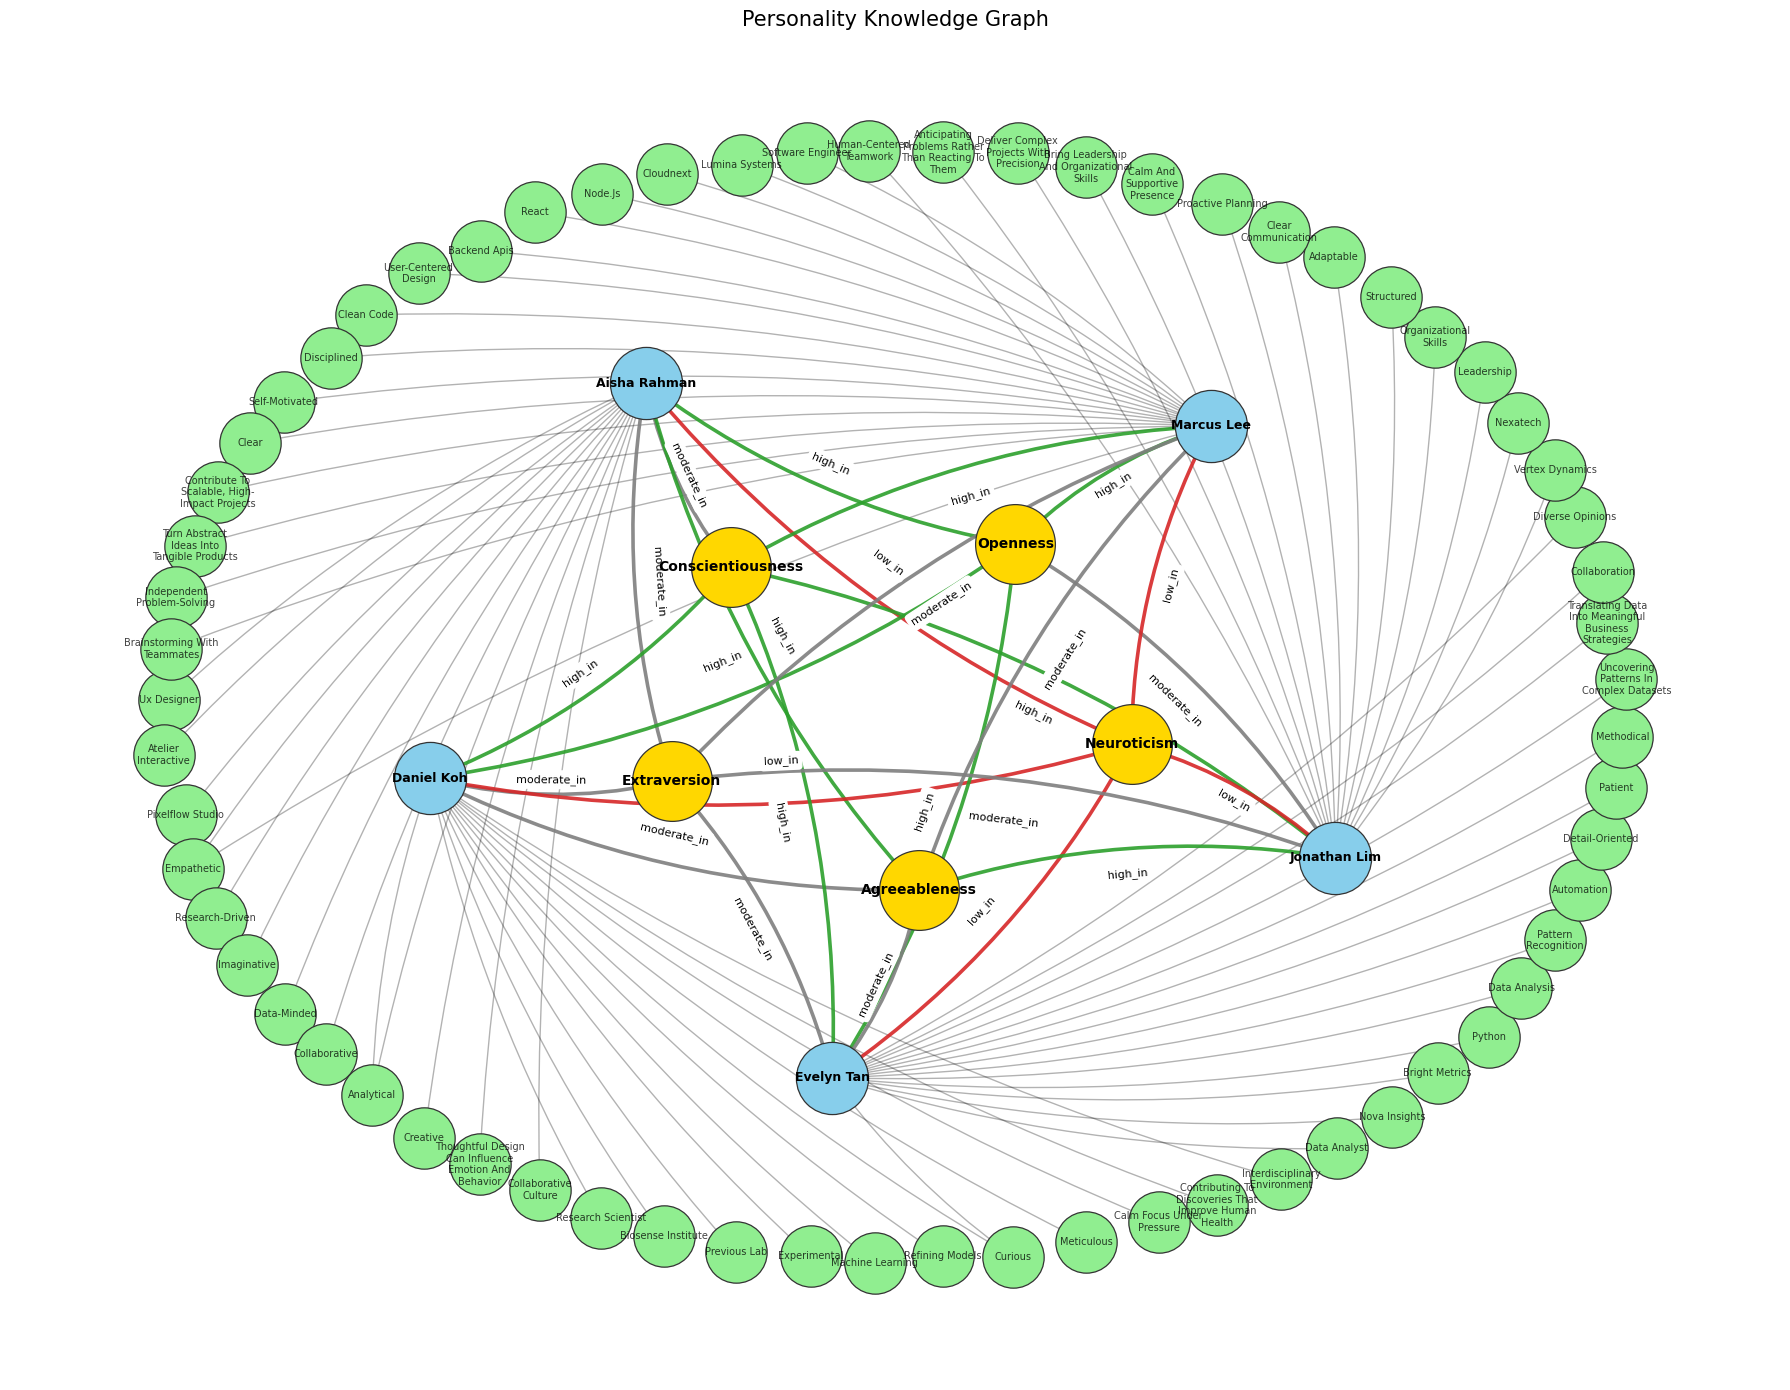

Exported: .gexf (Gephi), .graphml (Neo4j/other tools), and .png image.


In [110]:
# Group nodes by type
dims    = [n for n, d in G.nodes(data=True) if d.get("type") == "trait_dimension"]
people  = [n for n, d in G.nodes(data=True) if d.get("type") == "person"]
others  = [n for n, d in G.nodes(data=True) if d.get("type") not in ("trait_dimension", "person")]

# Arrange layout in concentric rings
rings = []
if dims: rings.append(dims)
if people: rings.append(people)
if others: rings.append(others)
if not rings:
    rings = [list(G.nodes())]

pos = nx.shell_layout(G, nlist=rings, scale=4.8)  # slightly larger spread

# Slight jitter to reduce overlap
def jitter(nodes, amount=0.12):
    for n in nodes:
        if n in pos:
            x, y = pos[n]
            angle = random.random() * 2 * math.pi
            r = (random.random() - 0.5) * amount
            pos[n] = (x + r * math.cos(angle), y + r * math.sin(angle))

jitter(people, 0.18)
jitter(others, 0.12)

# Node colors and sizes
color_map = {
    "trait_dimension": "#FFD700",  
    "person": "#87CEEB",           
    "entity": "#90EE90"          
}
size_map = {"trait_dimension": 2200, "person": 1800, "entity": 1300}

plt.figure(figsize=(18, 14))

# Separate OCEAN edges from others
edges_to_dims = [(u, v) for u, v, e in G.edges(data=True) if v in dims]
edges_other   = [(u, v) for u, v, e in G.edges(data=True) if v not in dims]

# Draw faint edges for non-OCEAN links
nx.draw_networkx_edges(
    G, pos, edgelist=edges_other,
    width=1.0, alpha=0.3,
    arrows=True, arrowsize=8,
    connectionstyle="arc3,rad=0.08"
)

# Draw stronger colored edges for OCEAN relations
rel_color = {"high_in":"tab:green", "moderate_in":"tab:gray", "low_in":"tab:red"}
edge_colors_dims = [rel_color.get(G.edges[u, v].get("relation"), "tab:gray") for (u, v) in edges_to_dims]
nx.draw_networkx_edges(
    G, pos, edgelist=edges_to_dims,
    width=2.6, alpha=0.9,
    arrows=True, arrowsize=12,
    connectionstyle="arc3,rad=0.12",
    edge_color=edge_colors_dims
)

# Draw nodes by group
for group, t in [(others, "entity"), (people, "person"), (dims, "trait_dimension")]:
    if group:
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=group,
            node_color=color_map[t],
            node_size=size_map[t] * 1.5,
            edgecolors="#333",
            linewidths=0.9,
            label=t.capitalize()
        )

# Add text labels
def wrap(s, width=18):
    s = str(s)
    return "\n".join(textwrap.wrap(s, width=width)) if len(s) > width else s

labels_people = {n: wrap(n, 18) for n in people}
labels_dims   = {n: wrap(n, 18) for n in dims}
labels_others = {n: wrap(n, 18) for n in others}

nx.draw_networkx_labels(G, pos, labels=labels_people, font_size=9, font_weight="bold")
nx.draw_networkx_labels(G, pos, labels=labels_dims, font_size=10, font_weight="bold")
nx.draw_networkx_labels(G, pos, labels=labels_others, font_size=7, alpha=0.75)

# Edge relation labels
edge_labels = {(u, v): G.edges[u, v].get("relation", "") for (u, v) in edges_to_dims}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5)

# Final layout and export
plt.title("Personality Knowledge Graph", fontsize=15)
plt.axis("off")
plt.tight_layout()
plt.savefig("outputs/personality_knowledge_graph.png", bbox_inches="tight", dpi=300)
plt.show()

nx.write_gexf(G, "outputs/personality_knowledge_graph.gexf")
nx.write_graphml(G, "outputs/personality_knowledge_graph.graphml")
print("Exported: .gexf (Gephi), .graphml (Neo4j/other tools), and .png image.")

## Evaluation

In [109]:
# Paths
GOLD_DIR = Path("gold")
OUT_DIR  = Path("outputs")

GOLD_ENT = GOLD_DIR / "gold_entities_per_record.json"
GOLD_REL = GOLD_DIR / "gold_relations_per_record.json"
GOLD_PER = GOLD_DIR / "gold_personality_per_record.json"

PRED_ENT = OUT_DIR / "entities_per_record.json"
PRED_REL = OUT_DIR / "triples_augmented.json"
PRED_PER = OUT_DIR / "personality_inference.json"

# Helper functions
def norm_text(s: str) -> str:
    return " ".join((s or "").strip().split()).casefold()

def prf(tp, fp, fn):
    p = tp / (tp + fp) if (tp + fp) else 0.0
    r = tp / (tp + fn) if (tp + fn) else 0.0
    f = 2*p*r / (p + r) if (p + r) else 0.0
    return p, r, f

# Convert entity list to a normalized set of tuples
def to_entity_set(items):
    out = set()
    for e in (items or []):
        if not isinstance(e, dict): 
            continue
        t = e.get("text"); ty = e.get("type")
        if not t or not ty: 
            continue
        out.add((norm_text(t), (ty or "").strip().upper()))
    return out

# Convert triples (list or dict) into a normalized set of (subject, relation, object)
def to_triple_set(items):
    out = set()
    if not items: 
        return out
    for it in items:
        if isinstance(it, dict):
            s, r, o = it.get("subject"), it.get("relation"), it.get("object")
        else:
            if not (isinstance(it, (list, tuple)) and len(it) == 3): 
                continue
            s, r, o = it
        if not (s and r and o): 
            continue
        out.add((norm_text(s), norm_text(r), norm_text(o)))
    return out

def pearson(x, y):
    n = len(x)
    if n == 0: return None
    mx = sum(x)/n; my = sum(y)/n
    num = sum((a-mx)*(b-my) for a,b in zip(x,y))
    denx = math.sqrt(sum((a-mx)**2 for a in x))
    deny = math.sqrt(sum((b-my)**2 for b in y))
    if denx == 0 or deny == 0: return None
    return num/(denx*deny)

# Compute average ranks for ties
def _ranks(values):
    pairs = sorted((v,i) for i,v in enumerate(values))
    ranks = [0.0]*len(values)
    i = 0
    while i < len(pairs):
        j = i
        # collect tie block
        while j+1 < len(pairs) and pairs[j+1][0] == pairs[i][0]:
            j += 1
        # average rank of i..j (1-based ranks)
        avg = (i+1 + j+1)/2.0
        for k in range(i, j+1):
            ranks[pairs[k][1]] = avg
        i = j+1
    return ranks

def spearman(x, y):
    if len(x) == 0: return None
    rx = _ranks(x); ry = _ranks(y)
    return pearson(rx, ry)

def mae(x, y):
    if len(x) == 0: return None
    return sum(abs(a-b) for a,b in zip(x,y))/len(x)

def rmse(x, y):
    if len(x) == 0: return None
    return math.sqrt(sum((a-b)**2 for a,b in zip(x,y))/len(x))

# Safely load a JSON file if it exists
def safe_load(path):
    if not path.exists():
        print(f"⚠️ Missing file: {path}")
        return None
    return json.loads(path.read_text(encoding="utf-8"))

report = {}

# 1. Entity evaluation
gold_ent = safe_load(GOLD_ENT)
pred_ent = safe_load(PRED_ENT)

if gold_ent is not None and pred_ent is not None:
    gold_by_id = {row["id"]: to_entity_set(row.get("entities")) for row in gold_ent}
    pred_by_id = {row["id"]: to_entity_set(row.get("entities")) for row in pred_ent}

    all_ids = set(gold_by_id) | set(pred_by_id)
    TP=FP=FN=0
    per_type = defaultdict(lambda: Counter(tp=0, fp=0, fn=0))
    per_record = {}

    for rid in sorted(all_ids):
        g = gold_by_id.get(rid, set())
        p = pred_by_id.get(rid, set())
        tp = p & g
        fp = p - g
        fn = g - p

        TP += len(tp); FP += len(fp); FN += len(fn)
        for _, ty in tp: per_type[ty]["tp"] += 1
        for _, ty in fp: per_type[ty]["fp"] += 1
        for _, ty in fn: per_type[ty]["fn"] += 1

        pr, rc, f1 = prf(len(tp), len(fp), len(fn))
        per_record[rid] = {"precision": pr, "recall": rc, "f1": f1,
                           "tp": len(tp), "fp": len(fp), "fn": len(fn)}

    micro_p, micro_r, micro_f1 = prf(TP, FP, FN)
    per_type_metrics = {}
    for ty, c in per_type.items():
        P, R, F = prf(c["tp"], c["fp"], c["fn"])
        per_type_metrics[ty] = {"precision": P, "recall": R, "f1": F,
                                "tp": c["tp"], "fp": c["fp"], "fn": c["fn"]}

    report["entities"] = {
        "micro": {"precision": micro_p, "recall": micro_r, "f1": micro_f1, "tp": TP, "fp": FP, "fn": FN},
        "per_type": per_type_metrics,
        "per_record": per_record
    }
    print(f"[Entities] micro P={micro_p:.3f} R={micro_r:.3f} F1={micro_f1:.3f} (TP={TP}, FP={FP}, FN={FN})")
else:
    report["entities"] = {"note": "Missing gold or predictions; skipped."}

# 2. Relation evaluation
gold_rel = safe_load(GOLD_REL)
pred_rel = safe_load(PRED_REL) if PRED_REL.exists() else None

if gold_rel is not None and pred_rel is not None:
    # Normalize relation triples per record
    def triples_of(row):
        if isinstance(row, dict):
            return to_triple_set(row.get("triples"))
        elif isinstance(row, list):
            return to_triple_set(row)
        return set()

    if isinstance(gold_rel, list) and gold_rel and isinstance(gold_rel[0], dict) and "id" in gold_rel[0]:
        gold_by_id = {row["id"]: triples_of(row) for row in gold_rel}
    else:
        # global list
        gold_by_id = {"__all__": to_triple_set(gold_rel)}

    if isinstance(pred_rel, list) and pred_rel and isinstance(pred_rel[0], dict) and "id" in pred_rel[0]:
        pred_by_id = {row["id"]: triples_of(row) for row in pred_rel}
    else:
        pred_by_id = {"__all__": to_triple_set(pred_rel)}

    all_ids = set(gold_by_id) | set(pred_by_id)
    TP=FP=FN=0
    per_rel = defaultdict(lambda: Counter(tp=0, fp=0, fn=0))
    per_record = {}

    for rid in sorted(all_ids):
        g = gold_by_id.get(rid, set())
        p = pred_by_id.get(rid, set())
        tp = p & g
        fp = p - g
        fn = g - p

        TP += len(tp); FP += len(fp); FN += len(fn)

        # Track relation types
        for s,r,o in tp: per_rel[r]["tp"] += 1
        for s,r,o in fp: per_rel[r]["fp"] += 1
        for s,r,o in fn: per_rel[r]["fn"] += 1

        pr, rc, f1 = prf(len(tp), len(fp), len(fn))
        per_record[rid] = {"precision": pr, "recall": rc, "f1": f1,
                           "tp": len(tp), "fp": len(fp), "fn": len(fn)}

    micro_p, micro_r, micro_f1 = prf(TP, FP, FN)
    per_rel_metrics = {}
    for r, c in per_rel.items():
        P, R, F = prf(c["tp"], c["fp"], c["fn"])
        per_rel_metrics[r] = {"precision": P, "recall": R, "f1": F,
                              "tp": c["tp"], "fp": c["fp"], "fn": c["fn"]}

    report["relations"] = {
        "micro": {"precision": micro_p, "recall": micro_r, "f1": micro_f1, "tp": TP, "fp": FP, "fn": FN},
        "per_relation": per_rel_metrics,
        "per_record": per_record
    }
    print(f"[Relations] micro P={micro_p:.3f} R={micro_r:.3f} F1={micro_f1:.3f} (TP={TP}, FP={FP}, FN={FN})")
else:
    report["relations"] = {"note": "Missing gold or predictions; skipped."}

# 3. Personality (OCEAN) evaluation
gold_per = safe_load(GOLD_PER)
pred_per = safe_load(PRED_PER)

# Compare gold and predicted personality scores per dimension
if gold_per is not None and pred_per is not None:
    gold_by_id = {row["id"]: (row.get("big_five") or {}) for row in gold_per}
    pred_by_id = {row["id"]: (row.get("big_five") or {}) for row in pred_per}

    dims = ["openness","conscientiousness","extraversion","agreeableness","neuroticism"]
    results = {}

    common_ids = [rid for rid in gold_by_id.keys() if rid in pred_by_id]
    if not common_ids:
        results["note"] = "No overlapping ids between gold and predictions."
    else:
        for dim in dims:
            gx = []; px = []
            for rid in common_ids:
                gv = gold_by_id[rid].get(dim)
                pv = pred_by_id[rid].get(dim)
                if isinstance(gv, (int,float)) and isinstance(pv, (int,float)):
                    gx.append(float(gv)); px.append(float(pv))
            if gx:
                results[dim] = {
                    "pearson_r": pearson(gx, px),
                    "spearman_rho": spearman(gx, px),
                    "mae": mae(gx, px),
                    "rmse": rmse(gx, px),
                    "n": len(gx)
                }
            else:
                results[dim] = {"note": "No comparable values for this dimension."}

    report["personality"] = results
    # Print short summary to console
    msg = " | ".join(
        f"{dim[:4].title()} r={results.get(dim,{}).get('pearson_r',None):.2f} "
        f"ρ={results.get(dim,{}).get('spearman_rho',None):.2f} "
        f"MAE={results.get(dim,{}).get('mae',None):.2f}"
        if isinstance(results.get(dim,{}).get('pearson_r',None), (int,float)) else f"{dim[:4].title()} n/a"
        for dim in dims
    )
    print(f"[Personality] {msg}")
else:
    report["personality"] = {"note": "Missing gold or predictions; skipped."}

# Save evaluation report
OUT_DIR.mkdir(parents=True, exist_ok=True)
(OUT_DIR / "eval_report.json").write_text(json.dumps(report, indent=2, ensure_ascii=False), encoding="utf-8")
print("\nSaved: outputs/eval_report.json")

[Entities] micro P=0.556 R=0.556 F1=0.556 (TP=40, FP=32, FN=32)
[Relations] micro P=0.515 R=0.522 F1=0.519 (TP=35, FP=33, FN=32)
[Personality] Open r=0.18 ρ=0.22 MAE=0.08 | Cons r=0.96 ρ=0.73 MAE=0.03 | Extr r=-0.27 ρ=-0.18 MAE=0.08 | Agre r=0.27 ρ=0.18 MAE=0.06 | Neur n/a

Saved: outputs/eval_report.json
